In [8]:
from importlib import reload
from typing import Dict, List

import numpy as np
import numpy.typing as npt
import scipy.io as sio
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses

from spectrogram import Spectrogram, split_spectrogram
from spectrogram import create_spectrogram
import spectrum_painting as sp

In [2]:
def load_data_from_matlab(file: str) -> npt.NDArray[np.complex128]:
    """
    Load the list of complex numbers from Matlab files.
    """
    # each complex number is in its own row and so is put in
    # its own array. 'squeeze' flattens the array.
    return sio.loadmat(file)["WaveformOut"].squeeze()


data: Dict[str, npt.NDArray[np.complex128]] = {
    "b": load_data_from_matlab("data/matlab/B_SNR30.mat"),
    "bw": load_data_from_matlab("data/matlab/BW_SNR30.mat"),
    "w": load_data_from_matlab("data/matlab/W_SNR30.mat"),
    "z": load_data_from_matlab("data/matlab/Z_SNR30.mat"),
    "zb": load_data_from_matlab("data/matlab/ZB_SNR30.mat"),
    "zw": load_data_from_matlab("data/matlab/ZW_SNR30.mat"),
    "zbw": load_data_from_matlab("data/matlab/ZBW_SNR30.mat"),
}

In [3]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

In [4]:
# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data.items()}

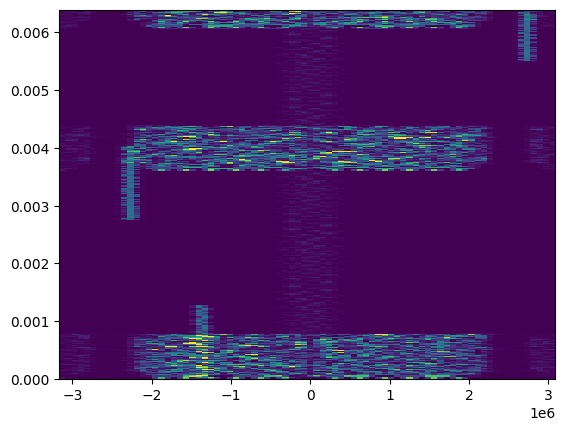

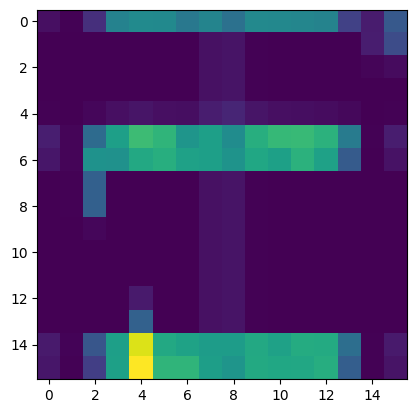

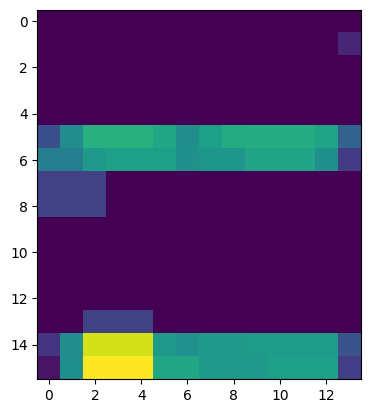

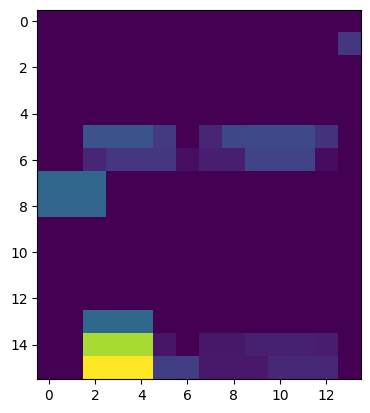

In [17]:
reload(sp)
middle: int = len(spectrograms["zbw"].values) // 2
start_freq: int = middle - 40
end_freq: int = middle + 40

demo_spectrogram = sp.take_frequencies(spectrograms["zbw"], start_freq, end_freq)
demo_spectrogram = split_spectrogram(demo_spectrogram, 1000)[0]
demo_spectrogram.values = demo_spectrogram.values.clip(0, 0.0000001)

plt.pcolormesh(demo_spectrogram.f, demo_spectrogram.t, demo_spectrogram.values.T, shading="nearest")
plt.show()

demo_spectrogram = sp.downsample_spectrogram(demo_spectrogram.values, 16)
plt.imshow(demo_spectrogram.T)
plt.show()

augmented_demo_spectrogram = sp.augment_spectrogram(spectrogram=demo_spectrogram, k=4, l=3, d=1)
plt.imshow(augmented_demo_spectrogram)
plt.show()

demo_spectrogram = sp.paint_spectrogram(demo_spectrogram, augmented_demo_spectrogram)
demo_spectrogram = sp.digitize_spectrogram(demo_spectrogram, 256)
plt.imshow(demo_spectrogram)
plt.show()

ValueError: num must be an integer with 1 <= num <= 280, not 281

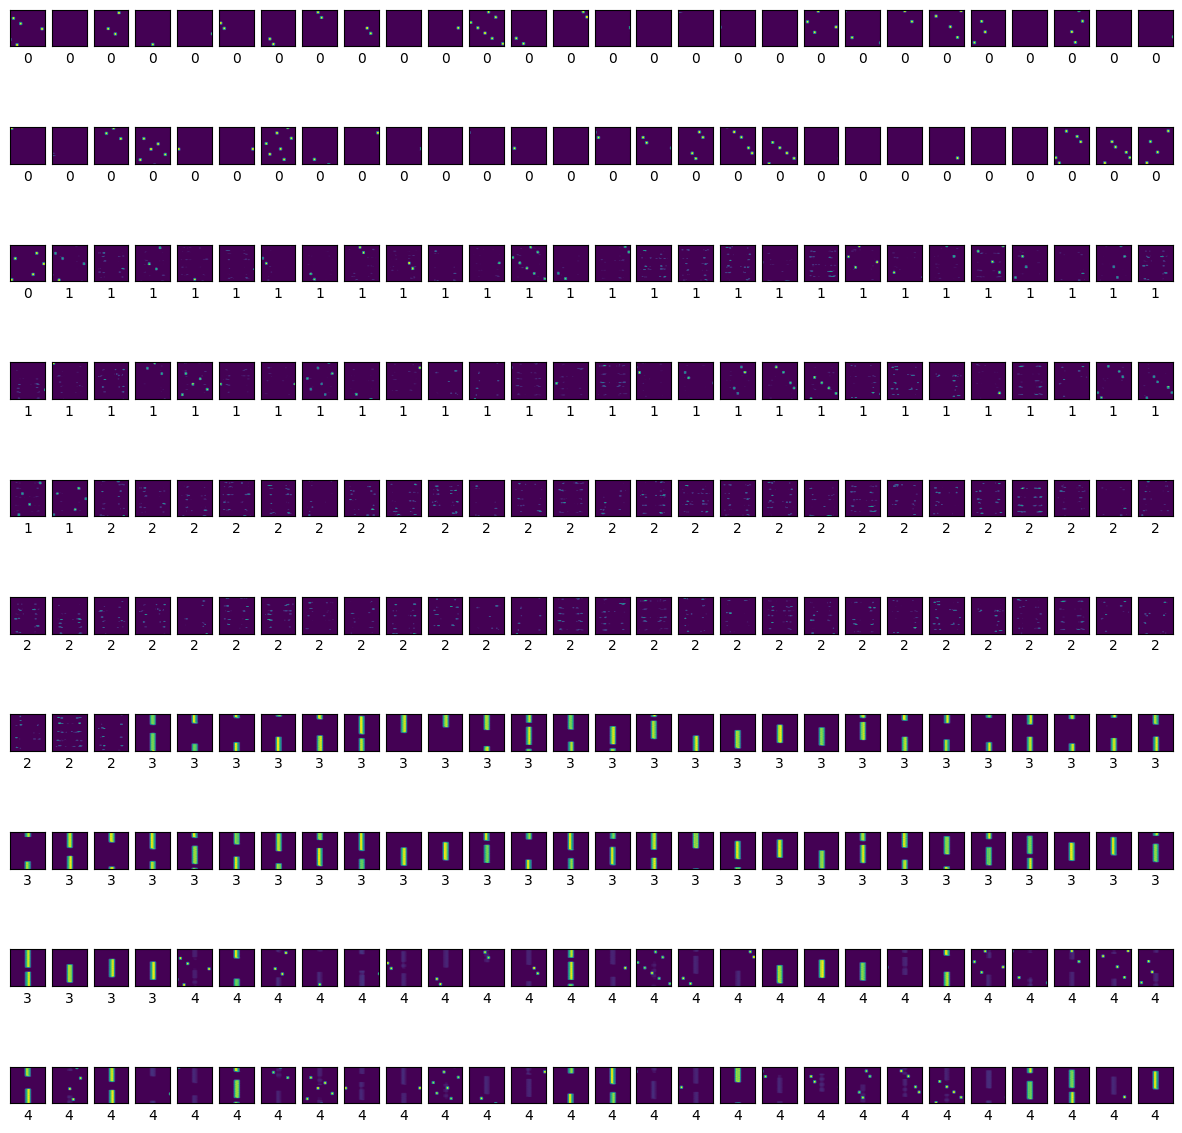

In [20]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you told the computer
# to do.
reload(sp)

downsample_resolution = 60

K = 3
L = 4
D = 1

color_depth = 256

x_train_augmented: [npt.NDArray[npt.NDArray[np.float32]]] = []
x_train_painted: [npt.NDArray[npt.NDArray[np.float32]]] = []
labels: [np.uint8] = []

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 30
    end_freq: int = middle + 30

    spec = sp.take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=3000)

    downsampled_slices = [sp.downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [sp.augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    for s in augmented_slices:
        x_train_augmented.append(sp.digitize_spectrogram(s, color_depth))

    painted_slices = [sp.paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    for s in painted_slices:
        x_train_painted.append(sp.digitize_spectrogram(s, color_depth))

    for i in range(len(slices)):
        labels.append(class_index)

plt.figure(figsize=(15, 15))
for i in range(len(x_train_painted)):
    image = x_train_painted[i]
    plt.subplot(10, 28, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[i])
plt.show()

x_train_combined = np.stack((x_train_augmented, x_train_painted), axis=3)

x_train, x_test, y_train, y_test = train_test_split(x_train_combined, labels, test_size=0.3, random_state=42)

# for tensorflow it must be uint8 and not a Python int.
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

print(f"Number of training images: {len(x_train)}")


In [ ]:
image_shape = x_train_augmented[0].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

augmented_input = layers.Input(shape=input_shape)
augmented_model = layers.Conv2D(filters=8, kernel_size=(7, 7), activation='relu')(augmented_input)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

# Flatten the 3D image output to 1 dimension
augmented_model = layers.Flatten()(augmented_model)
painted_input = layers.Input(shape=input_shape)
painted_model = layers.Conv2D(filters=8, kernel_size=(7, 7), activation='relu', input_shape=input_shape)(painted_input)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

# Flatten the 3D image output to 1 dimension
painted_model = layers.Flatten()(painted_model)

output = layers.Concatenate()([augmented_model, painted_model])
output = layers.Dense(64, activation='relu')(output)

label_count = len(spectrograms)
output = layers.Dense(label_count)(output)

model = models.Model(inputs=[augmented_input, painted_input], outputs=[output])

model.summary()
tf.keras.utils.plot_model(model, to_file="output/model.png")

In [ ]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# convert ints to the type of int that can be used in a Tensor
history = model.fit(x=[x_train_augmented, x_train_painted], y=y_train, epochs=10,
                    validation_data=([x_test_augmented, x_test_painted], y_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')

In [ ]:
final_loss, final_acc = model.evaluate([x_test_augmented, x_test_painted], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

In [ ]:
output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(model, "output/")
model.save(output_file)

In [ ]:
# Convert the model
# This requires TensorFlow 2.15.0 for it to work. See https://github.com/tensorflow/tensorflow/issues/63987
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# TensorFlow Lite Micro does not support Hybrid models so disable the default optimizations for now
# until full quantization can be done.
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Converting...")
tflite_model = converter.convert()
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
# Predict with full Tensorflow
test_img_augmented = x_test_augmented[0]
test_img_painted = x_test_painted[0]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))

predictions_single = model.predict(x=[(test_img_augmented, test_img_painted)])
prediction_index = np.argmax(predictions_single[0])
print(label_names[prediction_index])


In [ ]:
# Test with Tensorflow Lite

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

interpreter.set_tensor(0, test_img_augmented)
interpreter.set_tensor(1, test_img_painted)

interpreter.invoke()

prediction = interpreter.get_tensor(output_details["index"])[0]
print(prediction)
prediction_index = np.argmax(prediction)
print(label_names[prediction_index])

In [ ]:
test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.tobytes())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.tobytes())

# with serial.Serial("/dev/cu.usbmodem2101", timeout=5) as ser:
#     ser.write(augmented_bytes)
#     ser.write(painted_bytes)
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
